# Binary catch

**При каких условиях два тела, налетающие друг на друга с бесконечности (в системе центра масс) станут связной системой из-за испускания гравволн?**

In [1508]:
(* https://mathematica.stackexchange.com/questions/850/how-do-i-clear-all-user-defined-symbols/861#861 *)
<< Utilities`CleanSlate`
CleanSlate[];

ClearAll["Global`*"]
(* ClearSystemCache[] *)
(* https://mathematica.stackexchange.com/questions/111605/quit-vs-clearallglobal *)
if[Length[Names["Global`*"]] > 0, Remove["Global`*"]];

(* PacletInstall[
    "TensorSimplify",

    "Site" -> "http://raw.githubusercontent.com/carlwoll/TensorSimplify/master"
]*)
<<TensorSimplify`

  (CleanSlate) Contexts purged: {Global`}
  (CleanSlate) Approximate kernel memory recovered: 48 Kb


## Einstein Summation

In [1517]:
ClearAll@EinsteinSummation

EinsteinSummation[in_List, arrays_] := Module[
  {res =
    isum[in -> Cases[Tally @ Flatten @ in, {_, 1}][[All, 1]], arrays]},
  res /; res =!= $Failed
  ]

EinsteinSummation[in_List -> out_, arrays_] := Module[
  {res = isum[in -> out, arrays]},
  res /; res =!= $Failed
  ]

isum[in_List -> out_, arrays_List] := Catch@Module[
  {indices, contracted, uncontracted, contractions, transpose},
  If[Length[in] != Length[arrays],
    Message[EinsteinSummation::length, Length[in], Length[arrays]];
    Throw[$Failed]];
  MapThread[
    If[IntegerQ@TensorRank[#1] && Length[#1] != TensorRank[#2],
      Message[EinsteinSummation::shape, #1, #2];
      Throw[$Failed]] &, {in, arrays}];
  indices = Tally[Flatten[in, 1]];
  If[DeleteCases[indices, {_, 1 | 2}] =!= {},
    Message[EinsteinSummation::repeat,
      Cases[indices, {x_, Except[1 | 2]} :> x]];
    Throw[$Failed]];
  uncontracted = Cases[indices, {x_, 1} :> x];
  If[Sort[uncontracted] =!= Sort[out],
    Message[EinsteinSummation::output, uncontracted, out];
    Throw[$Failed]];
  contracted = Cases[indices, {x_, 2} :> x];
  contractions = Flatten[Position[Flatten[in, 1], #]] & /@ contracted;
  transpose = FindPermutation[uncontracted, out];
  Activate@
    TensorTranspose[
      TensorContract[Inactive[TensorProduct] @@ arrays, contractions],
    transpose]]

EinsteinSummation::length =
  "Number of index specifications (`1`) does not match the number of \
tensors (`2`)";
EinsteinSummation::shape =
  "Index specification `1` does not match the tensor rank of `2`";
EinsteinSummation::repeat =
  "Index specifications `1` are repeated more than twice";
EinsteinSummation::output =
  "The uncontracted indices don't match the desired output";

In [1525]:
$Assumptions = {
  {OverHat[r][OverHat[t]], OverHat[t], rh} \[Element] PositiveReals
};

$\hat{r}_k$

^   ^ ^
Cos[ϕ[t]] r[t]

      ^   ^ ^
Sin[ϕ[t]] r[t]
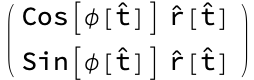

In [1527]:
rh = {OverHat[r][OverHat[t]]*Cos[\[Phi][OverHat[t]]], OverHat[r][OverHat[t]]*Sin[\[Phi][OverHat[t]]]};
rh // MatrixForm

## Система движения в декартовых координатах
$$
\frac{d^2r_k}{dt^2} = -\frac{G(m_A+m_B)}{r^3}r_k - \frac{2}{5}f_{ki}^{(5)}r_i
$$

Ч.Мизнер, К.Торн, Дж.Уилер Гравтация, Т.3 (36.8)

Введём обозначения для масс

$$
M=m_A+m_B; \quad
\mu = m_{AB} = \frac{m_A m_B}{M}
$$

### Безразмерные единицы длины
$$
\begin{align}
r &= b\hat{r} \\
t &= t_0\hat{t} \\
f_{ij} &= b^2\hat{f}_{ij} \\
f_{ij}^{(5)} &= \frac{b^2}{t_0^5}\hat{f}_{ij}^{(5)}
\end{align}
$$

$\hat{f}_{ki}$

^    ^ ^ 2
(1 + 3 Cos[2 ϕ[t]]) r[t]
-------------------------         ^         ^   ^ ^ 2
            6               Cos[ϕ[t]] Sin[ϕ[t]] r[t]

                                          ^  2  ^ ^ 2
                            (-1 + 3 Sin[ϕ[t]] ) r[t]
      ^         ^   ^ ^ 2   -------------------------
Cos[ϕ[t]] Sin[ϕ[t]] r[t]                3
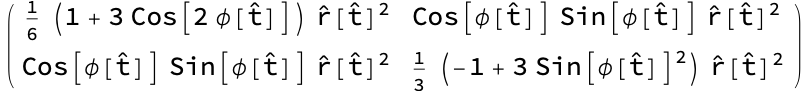

In [1529]:
fh = Simplify[Array[rh[[#]]*rh[[#2]] - 1/3*KroneckerDelta[#, #2]*(OverHat[r][OverHat[t]])^2 &, {2, 2}], Trig -> True];
fh // MatrixForm

$\hat{f}_{ki}^{(5)}$

^   (5)   ^   (5)
f         f
 x,x       x,y

^   (5)   ^   (5)
f         f
 x,y       y,y
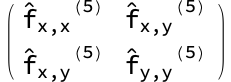

In [1533]:
(* fh5 = Array[Superscript[Subscript[OverHat[f], {x, y}[[#1]], {x, y}[[#2]]], "(5)"] &, {2, 2}] *)
(* Symmetric version *)
fh5 = Array[If[#1 <= #2,
                    Superscript[Subscript[OverHat[f], {x, y}[[#1]], {x, y}[[#2]]], "(5)"],
                    Superscript[Subscript[OverHat[f], {x, y}[[#2]], {x, y}[[#1]]], "(5)"]] &, {2, 2}];
fh5 // MatrixForm

$\hat{f}_{ki}^{(5)}\hat{r}_i$

^   ^   (5) ^ ^          ^   ^   (5) ^ ^
Cos[ϕ[t]] f       r[t] + Sin[ϕ[t]] f       r[t]
           x,x                      x,y

      ^   ^   (5) ^ ^          ^   ^   (5) ^ ^
Cos[ϕ[t]] f       r[t] + Sin[ϕ[t]] f       r[t]
           x,y                      y,y
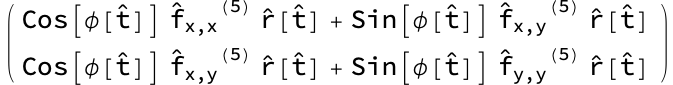

In [1535]:
fh5rh = EinsteinSummation[{{k, i}, {i}}, {fh5, rh}];
fh5rh // MatrixForm

Система движения в безразмерной записи будет выглядеть как

$$
\frac{d^2\hat{r}_k}{d\hat{t}^2} = -\frac{t_0^2}{b^3}\frac{GM}{\hat{r}^3}\hat{r}_k - \frac{2}{5}\frac{b^2}{t_0^3}\hat{f}_{ki}^{(5)}\hat{r}_i
$$

Пусть $t_0 = \sqrt{\frac{b^3}{GM}}$, а $b$ - прицельное расстояние, тогда система движения перепишется как

$$
\frac{d^2\hat{r}_k}{d\hat{t}^2} + \frac{\hat{r}_k}{\hat{r}^3} = - \frac{2}{5}\epsilon_G\hat{f}_{ki}^{(5)}\hat{r}_i\quad,
$$
или
$$
\hat{r}_k^{(2)} + \frac{\hat{r}_k}{\hat{r}^3} = - \frac{2}{5}\epsilon_G\hat{f}_{ki}^{(5)}\hat{r}_i\quad,
$$

где $ \epsilon_G = \frac{b^2}{t_0^3} = \frac{1}{b} \left( \frac{GM}{b} \right)^{\frac{3}{2}}$.

## Повернём систему с помощью матрицы вращения $R_{ij}(\phi)$ на угол $\phi$ по **часовой** стрелке
Переход к полярным координатам от декартовых

Cos[ϕ]    Sin[ϕ]

-Sin[ϕ]   Cos[ϕ]
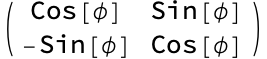

In [1536]:
RotationMatrix[-\[Phi]] // MatrixForm

#### LHS системы после поворота

^
Cos[ϕ[t]]           ^      ^   ^   ^    ^ ^           ^      ^ 2          ^       ^
--------- - 2 Sin[ϕ[t]] ϕ'[t] (r)'[t] + r[t] (-(Cos[ϕ[t]] ϕ'[t] ) - Sin[ϕ[t]] ϕ''[t]) + 
  ^ ^ 2
  r[t]
 
          ^    ^    ^
>   Cos[ϕ[t]] (r)''[t]

      ^
Sin[ϕ[t]]           ^      ^   ^   ^    ^ ^           ^      ^ 2          ^       ^
--------- + 2 Cos[ϕ[t]] ϕ'[t] (r)'[t] + r[t] (-(Sin[ϕ[t]] ϕ'[t] ) + Cos[ϕ[t]] ϕ''[t]) + 
  ^ ^ 2
  r[t]
 
          ^    ^    ^
>   Sin[ϕ[t]] (r)''[t]
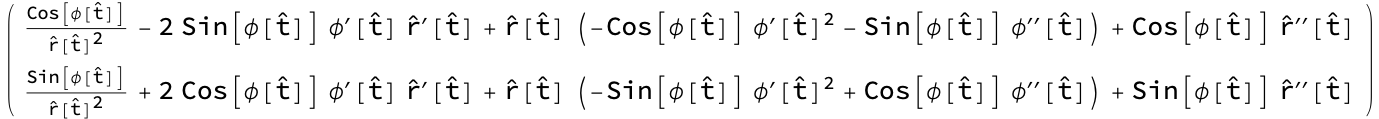

In [1572]:
LHSMotion = D[rh, {OverHat[t], 2}] + Simplify[rh / Norm[rh]^3];
LHSMotion // MatrixForm

^ ^ -2   ^ ^     ^ 2    ^    ^
r[t]   - r[t] ϕ'[t]  + (r)''[t]

     ^   ^   ^    ^ ^      ^
2 ϕ'[t] (r)'[t] + r[t] ϕ''[t]
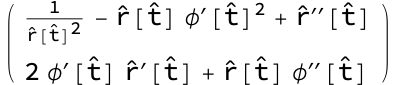

In [1576]:
RotatedLHSMotion = Simplify[RotationMatrix[-\[Phi][OverHat[t]]] . LHS, Trig -> True] // MatrixForm

Так как $\hat{\omega} \equiv \phi^{(1)}$, то

^ ^ -2   ^ ^  ^ ^ 2    ^    ^
r[t]   - r[t] ω[t]  + (r)''[t]

  ^ ^   ^   ^    ^ ^   ^   ^
2 ω[t] (r)'[t] + r[t] (ω)'[t]
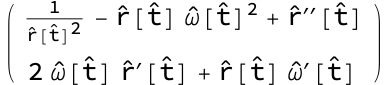

In [1578]:
OmegaReplace = Derivative[n_][\[Phi]][OverHat[t]] :> Derivative[n-1][OverHat[\[Omega]]][OverHat[t]];

OmegaLHSMotion = RotatedLHSMotion /. OmegaReplace

### RHS системы после поворота

^  2 ^   (5)           ^   ^   (5)         ^  2 ^   (5)  ^ ^
-2 ϵ  (Cos[ϕ[t]]  f       + Sin[2 ϕ[t]] f       + Sin[ϕ[t]]  f      ) r[t]
    G              x,x                   x,y                  y,y
--------------------------------------------------------------------------
                                    5



  1                 ^   ^   (5)           ^     ^   (5)   ^   (5)   ^ ^
-(-) (ϵ  (2 Cos[2 ϕ[t]] f       + Sin[2 ϕ[t]] (-f       + f      )) r[t])
  5    G                 x,y                     x,x       y,y
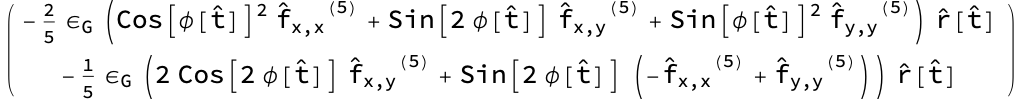

In [1580]:
RHSMotion = -2/5 Subscript[\[Epsilon], G] FullSimplify[RotationMatrix[-\[Phi][OverHat[t]]] . fh5rh, Trig -> True];
RHSMotion // MatrixForm

<span style="color:red">**NB:**</span> Полученные выражения <span style="color:green">**совпадают**</span> с уравнениями (10) и (9) из файла Binary.pdf

## Получим теперь **энергетическую** систему уравнений

В задача двух тел без учёта гравитационного излучения в системе центра масс в полярных координатах радиус-вектор $\hat{r}_k$ задаётся как:
$$
\hat{r}_k = \hat{r} e_{1k} \quad,
$$
где:
- $\hat{r}$ — расстояние между телами,
- $e_{1k}$ — единичный вектор в направлении $\hat{r}_k$.

Скорость в полярных координатах выражается как:
$$
\hat{r}_k^{(1)} = \hat{r}^{(1)} e_{1k} + \hat{r} \phi^{(1)} e_{2k} \quad,
$$
где:
- $\hat{r}^{(1)}$ — радиальная скорость
- $\hat{\omega} \equiv \phi^{(1)}$ — угловая скорость
- $e_{2k}$ — единичный вектор, перпендикулярный $e_{1k}$.

### **Кинетическая энергия**
Кинетическая энергия $T$ в полярных координатах выражается через радиальную и тангенциальную составляющие скорости:
$$
T = \frac{b^2}{2 t_0^2} (\hat{r}_k^{(1)})^2 = \frac{b^2}{2 t_0^2} \left( (\hat{r}^{(1)})^2 + \hat{r}^2 \hat{\omega}^2 \right) = \frac{G M}{b} \frac{1}{2}\left( (\hat{r}^{(1)})^2 + \hat{r}^2 \hat{\omega}^2 \right)
$$

### **Потенциальная энергия**
Потенциальная энергия $U$ зависит только от расстояния $\hat{r}$:
- Для гравитационного взаимодействия:
  $$
  U = -\frac{G m_A m_B}{b \hat{r}}.
  $$

### **Полная энергия**
Полная энергия $E$ в полярных координатах:
$$
E = T + U = \frac{G M}{b}\left(\frac{(\hat{r}^{(1)})^2}{2} + \frac{\hat{r}^2 \hat{\omega}^2}{2} - \frac{1}{\hat{r}}\right) = \frac{G M}{b} \hat{E}
$$

Здесь $\hat{E}$ - безразмерная энергия:

^ ^ 2 ^ ^ 2    ^   ^ 2
   1      r[t]  ω[t]    (r)'[t]
-(----) + ----------- + --------
  ^ ^          2           2
  r[t]
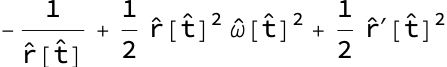

In [1544]:
Energy = (D[OverHat[r][OverHat[t]], OverHat[t]])^2/2 + (OverHat[r][OverHat[t]] OverHat[\[Omega]][OverHat[t]])^2/2 - 1/OverHat[r][OverHat[t]]

### **Момента импульса**
Момент импульса $J$ в системе центра масс:
$$
J = \frac{b^2}{t_0} \hat{r}^2 \hat{\omega} = (G M)^{1/2} b^{3/2} \hat{r}^2 \hat{\omega} = (G M)^{1/2} b^{3/2} \hat{J}
$$

Здесь $\hat{J}$ - безразмерный момент импульса:

^ ^ 2 ^ ^
r[t]  ω[t]
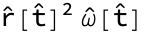

In [1545]:
AngularMomentum = (OverHat[r][OverHat[t]])^2 OverHat[\[Omega]][OverHat[t]]

Отсюда $\frac{1}{\hat{r}^{(1)}}\left(\frac{d\hat{E}}{d\hat{t}} - \hat\omega \frac{d\hat{J}}{d\hat{t}}\right)$

^ ^ -2   ^ ^  ^ ^ 2    ^    ^
r[t]   - r[t] ω[t]  + (r)''[t]
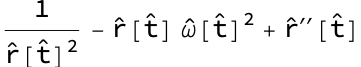

In [1546]:
Simplify[(D[Energy, OverHat[t]] - (AngularMomentum/OverHat[r][OverHat[t]]^2)(D[AngularMomentum, OverHat[t]]))/(D[OverHat[r][OverHat[t]], OverHat[t]])]

Что совпадает с **первой** строкой повернутой LHS системы движения

Отсюда $\frac{1}{\hat{r}}\frac{d\hat{J}}{d\hat{t}}$

^ ^   ^   ^    ^ ^   ^   ^
2 ω[t] (r)'[t] + r[t] (ω)'[t]
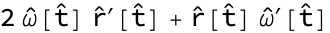

In [1547]:
Simplify[D[AngularMomentum, OverHat[t]]/OverHat[r][OverHat[t]]]

Что совпадает со **второй** строкой повернутой LHS системы движения

Таким образом, мы можем выписать новую **энергетическую** систему уравнений

$$
\begin{align}
\frac{d\hat{E}}{d\hat{t}} &= - \frac{2}{5}\epsilon_G \left(\hat{r}^{(1)} R_{xi}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j + \hat{r}\hat\omega R_{yi}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j \right)
\\
\frac{d\hat{J}}{d\hat{t}} &= - \frac{2}{5}\epsilon_G \hat{r} R_{yi}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j
\end{align}
$$

Или

$$
\left(\frac{d\hat{E}}{d\hat{t}}, \frac{d\hat{J}}{d\hat{t}}\right) = - \frac{2}{5} \epsilon_G T_{nk} R_{ki}(-\phi) \hat{f}_{ij}^{(5)}\hat{r}_j\quad,
$$

Чтобы перейти в размерный вид, достаточно положить $\epsilon_G \equiv 1$.

Здесь
$$
T = 
\begin{bmatrix}
\hat{r}^{(1)} & \hat{r}\hat\omega \\
0 & \hat{r}
\end{bmatrix}
$$
матрица трансофрмации:

^   ^      ^ ^  ^ ^
(r)'[t]     r[t] ω[t]

            ^ ^
0           r[t]
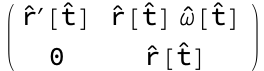

In [1549]:
Transform = {{D[OverHat[r][OverHat[t]], OverHat[t]], OverHat[r][OverHat[t]] OverHat[\[Omega]][OverHat[t]]}, {0, OverHat[r][OverHat[t]]}};
Transform // MatrixForm

Итак правая часть энергетической системы запишется как

^ ^               ^   ^   (5)           ^    ^   (5)   ^   (5)   ^ ^  ^ ^
(ϵ  r[t] ((-2 Cos[2 ϕ[t]] f       + Sin[2 ϕ[t]] (f       - f      )) r[t] ω[t] - 
  G                        x,y                    x,x       y,y
 
                 ^  2 ^   (5)           ^   ^   (5)         ^  2 ^   (5)   ^   ^
>       2 (Cos[ϕ[t]]  f       + Sin[2 ϕ[t]] f       + Sin[ϕ[t]]  f      ) (r)'[t])) / 5
                       x,x                   x,y                  y,y

  1                 ^   ^   (5)           ^     ^   (5)   ^   (5)   ^ ^ 2
-(-) (ϵ  (2 Cos[2 ϕ[t]] f       + Sin[2 ϕ[t]] (-f       + f      )) r[t] )
  5    G                 x,y                     x,x       y,y
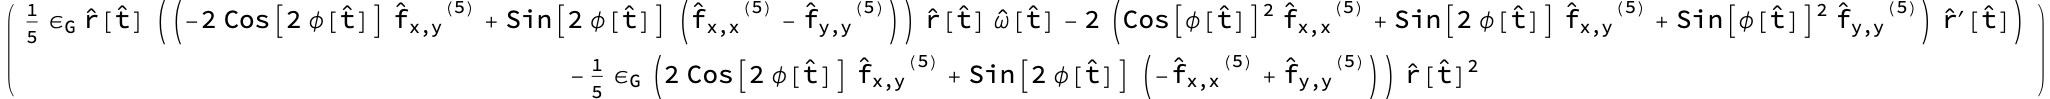

In [1563]:
RHSEnegry = FullSimplify[Transform . RHS, Trig -> True];
RHSEnegry // MatrixForm

## Другой Способ получения уравнений движения и энергетических уравнений через лагранжев формализм в полярных координатах

### **Лагранжиан системы**
Лагранжиан $L$ в полярных координатах $(r, \phi)$ выражается как:
$$
L = T - (U + \Phi),
$$
где:
- $T$ — кинетическая энергия,
- $U$ — потенциальная энергия
- $\Phi = \frac{1}{5}f_{ij}^{(5)}r_i r_j = \frac{\epsilon_G}{5}\frac{b^2}{t_0^2}\hat{f}_{ij}^{(5)}\hat{r}_i \hat{r}_j = \epsilon_G\frac{GM}{b}\hat{\Phi}$ - малый потенциал "реакции излучения"

Безразмерный малый потенциал "реакции излучения" $\hat{\Phi} = \frac{1}{5}\hat{f}_{ij}^{(5)}\hat{r}_i\hat{r}_j$

^   ^ ^         ^   ^   (5) ^ ^          ^   ^   (5) ^ ^
(Cos[ϕ[t]] r[t] (Cos[ϕ[t]] f       r[t] + Sin[ϕ[t]] f       r[t]) + 
                            x,x                      x,y
 
            ^   ^ ^         ^   ^   (5) ^ ^          ^   ^   (5) ^ ^
>     Sin[ϕ[t]] r[t] (Cos[ϕ[t]] f       r[t] + Sin[ϕ[t]] f       r[t])) / 5
                                 x,y                      y,y
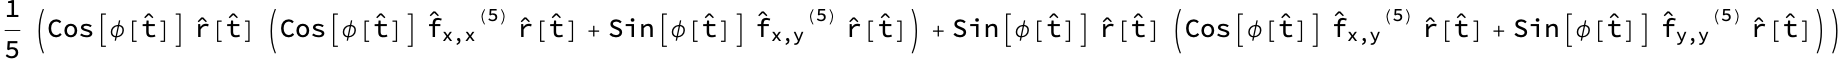

In [1555]:
fh5rhrh = 1/5 EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, rh, rh}];
fh5rhrh

Безразмерный лагранжиан

$$
\hat{L} = \hat{T} - (\hat{U} + \epsilon_G\hat{\Phi}),
$$
или
$$
\hat{L} = \frac{1}{2} \left((\hat{r}^{(1)})^2 + \hat{r}^2 \hat{\omega}^2 \right) + \frac{1}{\hat{r}} - \frac{\epsilon_G}{5}\hat{f}_{ij}^{(5)}\hat{r}_i \hat{r}_j.
$$

### **Уравнения Эйлера-Лагранжа**
Уравнения Эйлера-Лагранжа имеют вид:
$$
\frac{d}{dt} \left( \frac{\partial \hat{L}}{\partial \dot{q}_i} \right) - \frac{\partial \hat{L}}{\partial q_i} = 0,
$$
где $q_i$ — обобщённые координаты ($\hat{r}$ и $\phi$).

---

#### Уравнение для координаты $\hat{r}$:
$$
\frac{d}{d\hat{t}} \left(\frac{\partial \hat{L}}{\partial \hat{r}^{(1)}} \right) - \frac{\partial \hat{L}}{\partial \hat{r}} = 0.
$$
Вычислим производные:
$$
\frac{\partial \hat{L}}{\partial \hat{r}^{(1)}} = \hat{r}^{(1)}, \quad \frac{d}{d\hat{t}} \left( \frac{\partial \hat{L}}{\partial \hat{r}^{(1)}} \right) = \hat{r}^{(2)},
$$
$$
\frac{\partial \hat{L}}{\partial \hat{r}} = \hat{r} \hat{\omega}^2 - \frac{1}{\hat{r}^2} - \epsilon_G\frac{\partial \hat{\Phi}}{\partial \hat{r}}.
$$
Подставляем в уравнение Эйлера-Лагранжа:
$$
\hat{r}^{(2)} - \hat{r} \hat{\omega}^2 + \frac{1}{\hat{r}^2} = - \epsilon_G\frac{\partial \hat{\Phi}}{\partial \hat{r}}.
$$

Это **радиальное уравнение движения**.

Здесь 
$$
\frac{\partial \hat{\Phi}}{\partial \hat{r}} = \frac{1}{5}\hat{f}_{ij}^{(5)}\left(\frac{\partial \hat{r}_i}{\partial \hat{r}}\hat{r}_j + \hat{r}_i\frac{\partial \hat{r}_j}{\partial \hat{r}}\right)
$$
<span style="color:red">**TODO:**</span> Обсудить почему $\hat{f}_{ij}^{(5)}$ берётся заданной функцией, не зависящей от $\hat{r}$ при вариации лагранжиана.

Правая часть радиального уравнения движения будет выглядеть как

^  2 ^   (5)           ^   ^   (5)         ^  2 ^   (5)  ^ ^
-2 ϵ  (Cos[ϕ[t]]  f       + Sin[2 ϕ[t]] f       + Sin[ϕ[t]]  f      ) r[t]
    G              x,x                   x,y                  y,y
--------------------------------------------------------------------------
                                    5
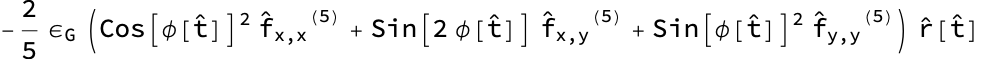

In [1586]:
RHSMotionRadialLagrange = - 1/5 Subscript[\[Epsilon], G] FullSimplify[EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, D[rh, OverHat[r][OverHat[t]]], rh}] + EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, rh, D[rh, OverHat[r][OverHat[t]]]}]]

<span style="color:red">**NB:**</span> Выражение <span style="color:green">**совпадает**</span> с раннее полученным уравнением и с уравнением (10) из файла Binary.pdf

In [1587]:
RHSMotion[[1]] - RHSMotionRadialLagrange

0

---

#### Уравнение для координаты $\phi$:
$$
\frac{d}{d\hat{t}} \left(\frac{\partial \hat{L}}{\partial \hat{\omega}} \right) - \frac{\partial \hat{L}}{\partial \phi} = 0.
$$
Вычислим производные:
$$
\frac{\partial \hat{L}}{\partial \hat{\omega}} = \hat{r}^2 \hat{\omega}, \quad \frac{d}{d\hat{t}} \left( \frac{\partial \hat{L}}{\partial \hat{\omega}} \right) = \frac{d}{d\hat{t}} \left( \hat{r}^2 \hat{\omega} \right),
$$
$$
\frac{\partial \hat{L}}{\partial \phi} = - \epsilon_G\frac{\partial \hat{\Phi}}{\partial \phi}.
$$
Подставляем в уравнение Эйлера-Лагранжа:
$$
\frac{1}{\hat{r}}\frac{d}{d\hat{t}} \left( \hat{r}^2 \hat{\omega} \right) = \frac{1}{\hat{r}}\frac{d\hat{J}}{d\hat{t}} = - \frac{\epsilon_G}{\hat{r}}\frac{\partial \hat{\Phi}}{\partial \phi}.
$$

Здесь 
$$
\frac{\partial \hat{\Phi}}{\partial \phi} = \frac{1}{5}\hat{f}_{ij}^{(5)}\left(\frac{\partial \hat{r}_i}{\partial \phi}\hat{r}_j + \hat{r}_i\frac{\partial \hat{r}_j}{\partial \phi}\right)
$$
<span style="color:red">**TODO:**</span> Обсудить почему $\hat{f}_{ij}^{(5)}$ берётся заданной функцией, не зависящей от $\phi$ при вариации лагранжиана.

Правая часть уравнения движения для $\phi$ будет выглядеть как

1                 ^   ^   (5)           ^     ^   (5)   ^   (5)   ^ ^
-(-) (ϵ  (2 Cos[2 ϕ[t]] f       + Sin[2 ϕ[t]] (-f       + f      )) r[t])
  5    G                 x,y                     x,x       y,y
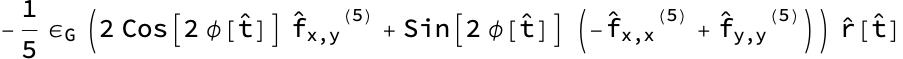

In [1595]:
RHSMotionPhiLagrange = - 1/5 Subscript[\[Epsilon], G] FullSimplify[EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, D[rh, \[Phi][OverHat[t]]], rh}] + EinsteinSummation[{{i, j}, {i}, {j}}, {fh5, rh, D[rh, \[Phi][OverHat[t]]]}]]/OverHat[r][OverHat[t]]

<span style="color:red">**NB:**</span> Выражение <span style="color:green">**совпадает**</span> с раннее полученным уравнением и с уравнением (9) из файла Binary.pdf

In [1597]:
RHSMotion[[2]] - RHSMotionPhiLagrange

0

## Получим **энергетическую** систему уравнений в подходе Лагранжа

Заметим, что энергия системы:
$$
\hat{E} = \frac{(\hat{r}^{(1)})^2}{2} + \frac{\hat{r}^2 \hat{\omega}^2}{2} - \frac{1}{\hat{r}}
$$
$$
\frac{1}{\hat{r}^{(1)}}\left(\frac{d\hat{E}}{d\hat{t}} - \hat{\omega} \frac{d\hat{J}}{d\hat{t}}\right) = \hat{r}^{(2)} - \hat{r} \hat{\omega}^2 + \frac{1}{\hat{r}^2}
$$

А также уравнение для изменения момента импульса системы есть
$$
\frac{d\hat{J}}{d\hat{t}} = - \epsilon_G\frac{\partial \hat{\Phi}}{\partial \phi}.
$$

Итоговая энергетическая система, выведенная по-новому будет записываться как:

$$
\begin{align}
\frac{d\hat{E}}{d\hat{t}} &= - \epsilon_G\left(\hat{r}^{(1)}\frac{\partial \hat{\Phi}}{\partial \hat{r}} + \hat{\omega} \frac{\partial \hat{\Phi}}{\partial \phi}\right) = - \epsilon_G \frac{d\hat{\Phi}}{d\hat{t}}
  = - \frac{\epsilon_G}{5}\hat{f}_{ij}^{(5)}\left(\frac{d\hat{r}_i}{d\hat{t}}\hat{r}_j + \hat{r}_i\frac{d\hat{r}_j}{d\hat{t}}\right)
\\
\frac{d\hat{J}}{d\hat{t}} &= - \epsilon_G\frac{\partial \hat{\Phi}}{\partial \phi} = - \frac{\epsilon_G}{5}\hat{f}_{ij}^{(5)}\left(\frac{\partial \hat{r}_i}{\partial \phi}\hat{r}_j + \hat{r}_i\frac{\partial \hat{r}_j}{\partial \phi}\right)
\end{align}
$$

И снова, чтобы перейти в размерный вид, достаточно положить $\epsilon_G \equiv 1$

То есть
$$
\begin{align}
\frac{dE}{dt} &= - \frac{d\Phi}{dt}
\\
\frac{dJ}{dt} &= - \frac{\partial \Phi}{\partial \phi}

\end{align}
$$
<span style="color:red">**TODO:**</span> Обсудить почему $\hat{f}_{ij}^{(5)}$ берётся заданной функцией, не зависящей от $\hat{r}, \phi, \hat{t}$ при вариации лагранжиана.

^ ^            ^   ^   (5)         ^         ^     ^   (5)   ^   (5)   ^ ^
(-2 ϵ  r[t] ((Cos[2 ϕ[t]] f       + Cos[ϕ[t]] Sin[ϕ[t]] (-f       + f      )) r[t] 
     G                     x,y                             x,x       y,y
 
         ^ ^           ^  2 ^   (5)           ^   ^   (5)         ^  2 ^   (5)   ^   ^
>        ω[t] + (Cos[ϕ[t]]  f       + Sin[2 ϕ[t]] f       + Sin[ϕ[t]]  f      ) (r)'[t]))
                             x,x                   x,y                  y,y
 
>     / 5

  1                 ^   ^   (5)           ^     ^   (5)   ^   (5)   ^ ^ 2
-(-) (ϵ  (2 Cos[2 ϕ[t]] f       + Sin[2 ϕ[t]] (-f       + f      )) r[t] )
  5    G                 x,y                     x,x       y,y
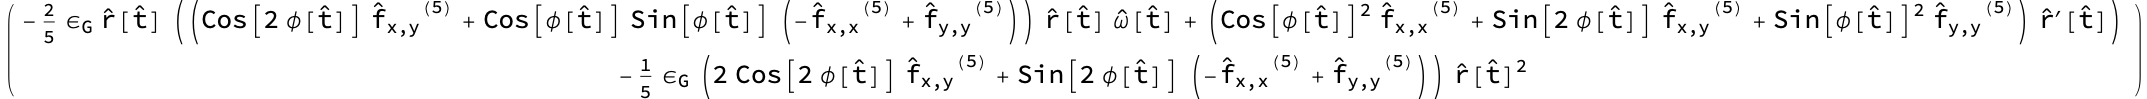

In [1602]:
RHSEnegryLagrange = - Subscript[\[Epsilon],G] FullSimplify[{
  D[fh5rhrh, OverHat[t]] /. OmegaReplace,
  D[fh5rhrh, \[Phi][OverHat[t]]]
}, Trig -> True];

RHSEnegryLagrange // MatrixForm

<span style="color:red">**NB:**</span> Выражения полностью <span style="color:green">**совпадают**</span> с предыдущим подходом!

0

0
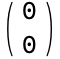

In [1603]:
FullSimplify[RHSEnegryLagrange - RHSEnegry] // MatrixForm

In [1440]:
fh1 = fh /. OverHat[r][OverHat[t]] -> Sqrt[Subscript[OverHat[r],2][OverHat[t]]];
fh51 = Simplify[D[fh1, {OverHat[t], 5}], Trig -> True];

fh5rhrh1 = 1/5 EinsteinSummation[{{i, j}, {i}, {j}}, {fh51, rh, rh}];
(* Simplify[{
  D[fh5rhrh1, OverHat[t]] /. OmegaReplace,
  D[fh5rhrh1, \[Phi][OverHat[t]]]
}, Trig -> True]; *)

(* Simplify[D[fh5rhrh1, \[Phi][OverHat[t]]], Trig -> True] *)

Simplify[D[fh5rhrh1, \[Phi][OverHat[t]]], Trig -> True]

0

^ ^ 5 ^  ^       ^ ^  ^  ^   ^   ^ 2       ^ ^ 2  ^   ^   ^    ^
-16 ω[t]  r [t] + 60 ω[t] r [t] (ω)'[t]  + 120 ω[t]  (ω)'[t] (r )'[t] + 
           2               2                                   2
 
       ^ ^ 2 ^  ^   ^    ^       ^ ^ 3  ^     ^        ^    ^   ^     ^
>   40 ω[t]  r [t] (ω)''[t] + 40 ω[t]  (r )''[t] - 10 (ω)''[t] (r )''[t] - 
              2                          2                       2
 
       ^    ^   ^ (3) ^        ^   ^   ^  (3) ^    ^  ^   ^ (4) ^      ^ ^   ^  (4) ^
>   5 (r )'[t] (ω)   [t] - 10 (ω)'[t] (r )   [t] - r [t] (ω)   [t] - 5 ω[t] (r )   [t]
        2                               2           2                         2
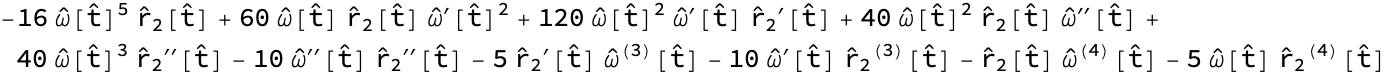

In [1331]:
(* fh1 = fh /. OverHat[r][OverHat[t]] -> Sqrt[Subscript[OverHat[r],2][OverHat[t]]]; *)
(* fh51 = Simplify[D[fh1, {OverHat[t], 5}], Trig -> True]; *)
Expand[Simplify[1/2(Sin[2\[Phi][OverHat[t]]] (fh51[[1,1]] - fh51[[2,2]]) - 2 Cos[2\[Phi][OverHat[t]]] fh51[[1,2]]) /. OmegaReplace, Trig -> True]]

^ ^ 5 ^  ^ 2      ^ ^  ^  ^ 2  ^   ^ 2      ^ ^ 2 ^  ^   ^   ^   ^    ^
16 ω[t]  r [t]  + 12 ω[t] r [t]  (ω)'[t]  + 24 ω[t]  r [t] (ω)'[t] (r )'[t] + 
          2                2                          2              2
 
       ^ ^ 3  ^    ^ 2     ^ ^ 2 ^  ^ 2  ^    ^       ^ ^ 3 ^  ^   ^     ^
>   24 ω[t]  (r )'[t]  - 4 ω[t]  r [t]  (ω)''[t] - 16 ω[t]  r [t] (r )''[t] + 
               2                  2                          2      2
 
       ^   ^   ^    ^   ^     ^    ^  ^   ^    ^   ^     ^      ^ ^   ^     ^ 2
>   3 (ω)'[t] (r )'[t] (r )''[t] + r [t] (ω)''[t] (r )''[t] + 3 ω[t] (r )''[t]  - 
                2        2          2               2                  2
 
    ^  ^   ^   ^   ^  (3) ^      ^ ^   ^    ^   ^  (3) ^
>   r [t] (ω)'[t] (r )   [t] - 2 ω[t] (r )'[t] (r )   [t]
     2              2                   2        2
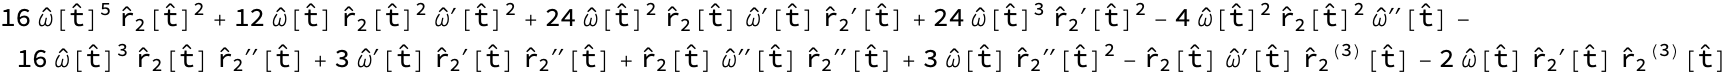

In [1338]:
fh2 = Array[If[#1 <= #2,
                    Superscript[Subscript[OverHat[f], {x, y}[[#1]], {x, y}[[#2]]], "(2)"],
                    Superscript[Subscript[OverHat[f], {x, y}[[#2]], {x, y}[[#1]]], "(2)"]] &, {2, 2}];
fh2 // MatrixForm;
fh3 = Array[If[#1 <= #2,
                    Superscript[Subscript[OverHat[f], {x, y}[[#1]], {x, y}[[#2]]], "(3)"],
                    Superscript[Subscript[OverHat[f], {x, y}[[#2]], {x, y}[[#1]]], "(3)"]] &, {2, 2}];
fh3 // MatrixForm;

fh2 = Simplify[D[fh1, {OverHat[t], 2}], Trig -> True];
fh3 = Simplify[D[fh1, {OverHat[t], 3}], Trig -> True];

Expand[Simplify[EinsteinSummation[{{i, j}, {i, l}, {l, j}}, {LeviCivitaTensor[2], fh2, fh3}] /. OmegaReplace, Trig -> True]]

# Интегрирование по частям
[Integrate By Parts](https://resources.wolframcloud.com/FunctionRepository/resources/IntegrateByParts/)
Contributed by: Wolfram|Alpha Math Team

In [ ]:
IntegrateByParts // ClearAll;
IntegrateByParts[ args___ ] :=
    Module[ { res },
        update[ ];
        res = Symbol[ "ResourceFunctionHelpers`IntegrateByParts" ][ args ];
        res /; Head @ res =!= Symbol[ "ResourceFunctionHelpers`IntegrateByParts" ]
    ];

In [ ]:
update // ClearAll;
update[ ] /; $VersionNumber <= 12 :=
    Once[

        If[ MemberQ[ PacletSites[ ], $publicPacletSite ],
            PacletManager`PacletUpdate[
                "ResourceFunctionHelpers",
                "Site"        -> "http://pacletserver.wolfram.com",
                "UpdateSites" -> True
            ]
        ];

        Quiet @ Block[ { $ContextPath }, Get[ "ResourceFunctionHelpers`" ] ]
    ];

In [ ]:
update // ClearAll;
update[ ] /; $VersionNumber <= 12 :=
    Once[

        If[ MemberQ[ PacletSites[ ], $publicPacletSite ],
            PacletManager`PacletUpdate[
                "ResourceFunctionHelpers",
                "Site"        -> "http://pacletserver.wolfram.com",
                "UpdateSites" -> True
            ]
        ];

        Quiet @ Block[ { $ContextPath }, Get[ "ResourceFunctionHelpers`" ] ]
    ];

$$
  I_4(u) = \int_{r_1}^\infty \frac{24r^2u^6 + 48u^6r + 120r^{3/2}u^4 - 96u^6 + 96u^4\sqrt{r} - u^2r^2 + 133u^2r - 2r^{3/2}}{r^4\sqrt{u^2r + 2\sqrt{r} - u^2}} \, dr,
$$
где при $r \ge r_1$ выражение $u^2r + 2\sqrt{r} - u^2 \ge 0$.

Всюду предполагается $u \gt 0$.

## Интегрант $f_4(u, r)$:

$$
  f_4(u, r) = \frac{24r^2u^6 + 48u^6r + 120r^{3/2}u^4 - 96u^6 + 96u^4\sqrt{r} - u^2r^2 + 133u^2r - 2r^{3/2}}{r^4\sqrt{u^2r + 2\sqrt{r} - u^2}}
$$

In [ ]:
integrand4[u_, r_] = (24*r^2*u^6 + 48*u^6*r + 120*r^(3/2)*u^4 - 96*u^6 + 96*u^4*Sqrt[r] - u^2*r^2 + 133*u^2*r - 2*r^(3/2)) /
  (r^4*Sqrt[u^2*r + 2*Sqrt[r] - u^2]);

Значение интегранта при любом $u$ на бесконечно больших $r$ равно 0:

In [ ]:
Limit[integrand4[u, r], r -> Infinity]

### Выражение для левой границы $r_1$

In [ ]:
eqr1[u_, r_] = u^2*r + 2*Sqrt[r] - u^2;
sol = Assuming[{u ∈ Reals, r ∈ Reals, r > 0}, Solve[eqr1[u, r] == 0, r]];
r1[u_] = Simplify[r/.sol[[1]]]

$r_1$ обращается в 0 при $u \rightarrow 0$:

In [ ]:
Series[r1[u], {u, 0, 5}]
Limit[r1[u], u -> 0]

И проверим, что знаменатель обращается в 0 при $r = r_1$

In [ ]:
PlotR1[u_] := Module[
  {points, r1Value},

  r1Value = Piecewise[{{0, u == 0}}, r1[u]];
  points = {{r1Value, eqr1[u, r1Value]}};

  plotLabel = "u = " <> ToString[u];

  Show[
    Plot[
      eqr1[u, r],
      {r, -1, 10},
      AxesLabel -> {"u", "r1"},
      PlotLabel -> plotLabel,
      PlotRange -> All
    ],
    ListPlot[
      points,
      PlotStyle -> {Red, PointSize[Large]}
    ]
  ]
]

plots = {PlotR1[3], PlotR1[0.1], PlotR1[0.0]};
GraphicsRow[plots]

### Графики функций интегранта $f_4(u_i, r)$:

In [ ]:
PlotIntegrand4[u_] := Module[
  {r1Value},

  r1Value = Piecewise[{{0, u == 0}}, r1[u]];

  plotLabel = "u = " <> ToString[u];

  Plot[
    integrand4[u, r],
    {r, r1Value, 10^3},
    PlotLabel -> plotLabel,
    PlotRange -> All,
    AxesOrigin -> {0, 0},
    AxesLabel -> {"r", "integrand4"},
    ScalingFunctions -> {"Log", "SignedLog"}
  ]
]

plots = {PlotIntegrand4[0.0], PlotIntegrand4[0.03], PlotIntegrand4[0.3]};
GraphicsRow[plots]

*Mathematica* очень долго берёт этот интеграл, но выдаёт огромную простыню выражений, которую не может упростить, используя при это коплексную экспоненту.

In [ ]:
Inactivate[Integrate[integrand4[u, r], {r, r1[u], Infinity}, Assumptions -> {u ∈ Reals, u > 0}]]

## Численный график $I_4(u)$ с использованием NIntegrate:

In [ ]:
Plot[
  NIntegrate[integrand4[u, r], {r, r1[u], Infinity}],
  {u, 1, 100},
  PlotLabel -> "NIntegral of integrand4",
  AxesLabel -> {"u", "integrand4"}
]

## Численный график $I_4(u)$ с использованием Integrate:

In [ ]:
(* points = With[
  {u := 10^up},
  Table[
    {u, N[Integrate[integrand4[u, r], {r, r1[u], Infinity}]]},
    {up, 0, 2, 0.05}
  ]
]; *)

points = Table[
  {u, N[Integrate[integrand4[u, r], {r, r1[u], Infinity}]]},
  {u, 1, 100, 1}
];

ListPlot[
  points,
  Joined -> True,
  PlotRange -> All,
  PlotLabel -> "Integral of integrand4",
  AxesLabel -> {"u", "integral4"}
]

## Первообразная $\tilde{I}_4(u, r)$:

In [ ]:
antiderivative4[u_, r_] = Integrate[integrand4[u, r], r]

Явно определим аргумент комплексного числа:

In [ ]:
(* complexLog[z_] := Log[Abs[z]] + I Arg[z]; *)
arg[z_] := ArcTan[ComplexExpand[Im[z]]/ComplexExpand[Re[z]]];
(* abs[z_] := ComplexExpand[Abs[z]]; *)

Применяя его к antiderivative4[u, r], мы получаем действительное выражение, состоящее из двух слагаемых одно без $\tan^{-1}$, а второе, включающее $\tan^{-1}$:

In [ ]:
antiderivative4s[u_, r_] =
  Simplify[
    ComplexExpand[
      Re[antiderivative4[u, r]]
    ] /. Arg -> arg,
    {{u, r} ∈ Reals, u > 0, r > r1[u]}
  ];

antiderivative4s[u_, r_] =
  Sqrt[2 Sqrt[r] - u^2 + r u^2] * Simplify[
    Expand[
      (antiderivative4s[u, r] /. ArcTan[x_] -> 0) /
      Sqrt[2 Sqrt[r] - u^2 + r u^2]
    ],
    {{u, r} ∈ Reals, u > 0, r > 0}
  ] -
  Cases[antiderivative4s[u, r],
    coeff_.*ArcTan[arg_] :> coeff*ArcTan[arg], ∞][[2]] /
  (12 * r^3 * u^7)

### График первообразной $\tilde{I}_4(u_i, r)$:

In [ ]:
rules = {
  eqr1[u, r] -> 0,
  ArcTan[x_] -> -Pi/2
};

PlotAntiderivative[u_] := Module[
  {points, antiderivative, r1Value},

  r1Value = r1[u]*(1.0+10^-12);
  antiderivative =
    If[r == r1Value,
      antiderivative4s[u, r] /. rules,
      antiderivative4s[u, r]
    ];

  points = {{r1Value, Re[antiderivative /. r -> r1Value]}};

  plotLabel = "u = " <> ToString[u];

  Show[
    Plot[
      antiderivative,
      {r, r1Value, r1Value*2.1},
      PlotLabel -> plotLabel,
      PlotRange -> All,
      AxesLabel -> {"r", "antiderivative4s"},
      ScalingFunctions -> {"SignedLog", "SignedLog"}
    ],
    ListPlot[
      points,
      PlotRange -> All,
      PlotStyle -> {Red, PointSize[Large]},
      ScalingFunctions -> {"SignedLog", "SignedLog"}
    ]
  ]
]

plots = {PlotAntiderivative[3], PlotAntiderivative[0.1], PlotAntiderivative[5*10.0^-2]};
GraphicsRow[plots]

## Определённый интеграл, возьмём как разницу первообразных по теореме Ньютона-Лейбница,
$$
  I_{4,1}(u) = \int_{r_1}^{\infty} f_4(u, r) \, dr = \tilde{I}_{4}(u, \infty) - \tilde{I}_{4}(u, r_1(u)):
$$

Найдём $\tilde{I}_{4}(u, \infty)$:

In [ ]:
integral4Inf[u_] = Limit[
  antiderivative4s[u, r],
  r -> Infinity,
  Assumptions -> {u ∈ Reals, u > 0}
];

integral4Infs[u_] = Simplify[
  ComplexExpand[
    Re[integral4Inf[u]]
  ] /. Arg -> arg,
  {{u, r} ∈ Reals, u > 0, r > r1[u]}
]

Найдём $\tilde{I}_{4}(r_1(u))$, при этом заметим, что $2\sqrt{r} - u^2 + r u^2 = 0$, и $\mathrm{arctan}(-\infty) = -\frac{\pi}{2}$:

In [ ]:
integral4r1[u_] = antiderivative4s[u, r] /. rules

### Графики функций $\tilde{I}_{4}(u, r_i)$:

In [ ]:
Plot[
  {
    N[antiderivative4s[u, 1]],
    N[antiderivative4s[u, 10^2]],
    N[antiderivative4s[u, 10^5]],
    N[antiderivative4s[u, 10^10]],
    N[integral4Infs[u]]
  },
  {u, 0, 1000},
  AxesLabel -> {"u", "antiderivative4"},
  PlotLegends -> {
    "antiderivative4s[r=1]",
    "antiderivative4s[r=10^2]",
    "antiderivative4s[r=10^5]",
    "antiderivative4s[r=10^10]",
    "antiderivative4s[r=Infinity]"
  },
  ScalingFunctions -> {"SignedLog", "SignedLog"}
]

In [ ]:
Plot[
  {
    N[Re[antiderivative4s[u, r1[u]+10^-2]]],
    N[Re[antiderivative4s[u, r1[u]+10^-4]]],
    N[Re[antiderivative4s[u, r1[u]+10^-5]]],
    N[Re[antiderivative4s[u, r1[u]+1.35*10^-6]]],
    N[Re[antiderivative4s[u, r1[u]+10^-7]]],
    N[Re[antiderivative4s[u, r1[u]+10^-10]]],
    N[Re[antiderivative4s[u, r1[u]+10^-12]]],
    N[integral4r1[u]]
  },
  {u, 0.0, 100},
  AxesLabel -> {"u", "antiderivative4"},
  PlotLegends -> {
    "antiderivative4s[r=r1[u]+10^{-2}]",
    "antiderivative4s[r=r1[u]+10^{-4}]",
    "antiderivative4s[r=r1[u]+10^{-5}]",
    "antiderivative4s[r=r1[u]+1.35*10^-6]",
    "antiderivative4s[r=r1[u]+10^{-7}]",
    "antiderivative4s[r=r1[u]+10^{-10}]",
    "antiderivative4s[r=r1[u]+10^{-12}]",
    "antiderivative4s[r=r1[u]]"
    },
  PlotRange -> All,
  ScalingFunctions -> {"Log", "SignedLog"}
]

## Итоговый ответ для $I_4(u)$:

In [ ]:
I4[u_] = Simplify[Collect[Simplify[integral4Infs[u] - integral4r1[u], {u ∈ Reals, u > 0}], (425 + 366*u^4 + 37*u^8)]]

In [ ]:
TeXForm[I4[u]]

## Сравнение Integrate и аналитической $I_4(u)$

In [ ]:
Show[
  Plot[
    N[I4[u]],
    {u, 0, 100},
    PlotLabel -> Subscript["I", 4][u],
    AxesLabel -> {"u", Subscript["I", 4]},
    PlotLegends -> {Subscript["I", 4][u]},
    ScalingFunctions -> {"SignedLog", "SignedLog"}
  ],
  ListPlot[
    points,
    (* Joined -> True, *)
    Mesh -> All,
    PlotStyle -> {Red, Dashed},
    PlotLegends -> {Subscript["Integrate I", 4][u]},
    ScalingFunctions -> {"SignedLog", "SignedLog"}
  ]
]

In [ ]:
points01 = Table[{u, N[Integrate[integrand4[u, r], {r, r1[u], Infinity}]]}, {u, 0.02, 1, 0.05}];
Show[
  Plot[
    N[I4[u]],
    {u, 0, 1},
    PlotLabel -> Subscript["I", 4][u],
    AxesLabel -> {"u", Subscript["I", 4]},
    PlotLegends -> {Subscript["I", 4][u]},
    ScalingFunctions -> {"SignedLog", "SignedLog"}
  ],
  ListPlot[
    points01,
    (* Joined -> True, *)
    Mesh -> All,
    PlotStyle -> {Red, Dashed},
    PlotLegends -> {Subscript["Integrate I", 4][u]},
    ScalingFunctions -> {"SignedLog", "SignedLog"}
  ]
]

$$I_1 = \hat{r}_2 \left[ 120\hat{r}_2^{(1)}\omega^2\omega^{(1)} - 5\hat{r}_2^{(1)}\omega^{(3)} - 16\hat{r}_2\omega^5 - 10\hat{r}_2^{(2)}\omega^{(2)} + 60\hat{r}_2\omega(\omega^{(1)})^2
- 10\hat{r}_2^{(3)}\omega^{(1)} + 40\hat{r}_2^{(2)}\omega^3 - 5\hat{r}_2^{(4)}\omega - \hat{r}_2\omega^{(4)} + 40\hat{r}_2\omega^2\omega^{(2)} \right]$$

$$I_2 = 2\hat{r}_2 \left[ -40\hat{r}_2\omega^3\omega^{(1)} - 20\omega^4\hat{r}_2^{(1)} + 5\hat{r}_2\omega\omega^{(3)} + 10\hat{r}_2\omega^{(1)}\omega^{(2)} + 10\omega^2\hat{r}_2^{(3)} + 30\omega\omega^{(1)}\hat{r}_2^{(2)} + 20\omega\omega^{(2)}\hat{r}_2^{(1)} + 15\hat{r}_2^{(1)}(\omega^{(1)})^2 - \frac{1}{3}\hat{r}_2^{(5)} \right]$$